In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np
from scipy import sparse
from models.models import MLP, GCN, SLR
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result
from models.utils import setup_aggregates, hierarchical_clustering, max_pool
from models.models import EmbeddingLayer
from torch_scatter import scatter_add, scatter_max


In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Converting one-hot labels to integers


In [3]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB


In [4]:
nb_genes = 2000
neighbors = gene_graph.bfs_sample_neighbors("RPL3", nb_genes)
adj = nx.to_scipy_sparse_matrix(neighbors)

In [5]:
clusters = hierarchical_clustering(adj, 1000)

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=50, test_size=1000, random_state=1)
X_train = X_train[list(neighbors.nodes)].copy()
inputs = torch.FloatTensor(np.expand_dims(X_train, axis=2))[0: 10]
inputs = Variable(inputs, requires_grad=False).float()
embedded_inputs = EmbeddingLayer(nb_genes)(inputs)
embedded_inputs = embedded_inputs.cuda().contiguous()
embedded_inputs = embedded_inputs.permute(0, 2, 1).contiguous()


In [7]:
embedded_inputs = embedded_inputs.cuda()
clusters = torch.tensor(clusters).cuda()

In [12]:
%timeit max_pool(embedded_inputs, clusters)

2.48 ms ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
clusters

In [38]:
# I removed this code, but it was the old crappy way of doing this.
# Also, doing big matrix multiplies is not viable for clinical tasks until we get GPUs with 400 gigs of ram
# %timeit sparse_max_pool(adjs[0], centroids[0], inputs.cuda())

1.13 s ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
results = pd.read_pickle("experiments/results/perf.pkl")

In [123]:
cuda_results = results[results["exp"] == "torch-scatter-cuda"]
cpu_results = results[results["exp"] == "torch-scatter-cpu"]
scatter_cuda_times = cuda_results.groupby("num_genes")["time_elapsed"].mean()
scatter_cpu_times = cpu_results.groupby("num_genes")["time_elapsed"].mean()

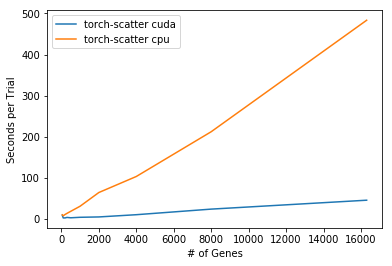

In [124]:
plt.plot(scatter_cuda_times, label="torch-scatter cuda")
plt.plot(scatter_cpu_times, label="torch-scatter cpu")
plt.xlabel("# of Genes")
plt.ylabel("Seconds per Trial")
plt.legend()

In [126]:
scatter_cuda_times

num_genes
50        8.872047
100       2.268636
200       2.239667
300       3.446151
500       2.551242
1000      3.746726
2000      4.611657
4000     10.058063
8000     23.667645
16300    45.356163
Name: time_elapsed, dtype: float32

In [125]:
scatter_cpu_times

num_genes
50         9.739996
100        7.451807
200       10.669987
300       13.329312
500       18.289906
1000      30.711226
2000      64.039383
4000     103.071251
8000     212.067078
16300    483.467316
Name: time_elapsed, dtype: float32